In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import numpy as np
import torch
import matplotlib.pyplot as plt
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import GaussianFilter
from outlier_detection import (
    global_outlier_detection,
    local_outlier_detection,
    edge_outlier_detection,
    combined_outlier_detection,
    analyze_outlier_masks,
    remove_outliers_iteratively
)

In [16]:
# -----------------------------------------------------------------------------
# 1. Read the minimal listmode events from the .lmf file.
# -----------------------------------------------------------------------------
# The minimal file contains only detector ID pairs, stored as int16.
dtype_minimal = np.dtype([('det1_id', np.uint16), ('det2_id', np.uint16)])
lmf_file = r"E:\Datasets\listmode_train\1000000000\cropped\listmode_data_minimal_9_1000000000.npz"
with np.load(lmf_file) as f:
    events_np = f['listmode']
# events_np = np.fromfile(lmf_file, dtype=dtype_minimal)
# Convert to a 2D array of shape (N, 2) where each row is [det1_id, det2_id].
detector_ids_np = np.column_stack((events_np['det1_id'], events_np['det2_id']))

# Convert the numpy array to a torch.Tensor.
detector_ids = torch.from_numpy(detector_ids_np).long()

In [10]:
# -----------------------------------------------------------------------------
# 2. Read the scanner lookup table (LUT) from the text file.
# -----------------------------------------------------------------------------
# The LUT file is assumed to have a header line, then rows: "detector_id x y z".
lut_file = 'detector_lut.txt'
# Skip the header (first line) and load the rest.
lut_data = np.loadtxt(lut_file, skiprows=1)
# The LUT has the detector id in the first column; the remaining columns are x, y, z.
scanner_lut_np = lut_data[:, 1:4]  # shape: (N_detectors, 3)
# Convert the LUT to a torch.Tensor.
scanner_lut = torch.from_numpy(scanner_lut_np).float()

In [18]:
# -----------------------------------------------------------------------------
# 3. Create the PET listmode projection metadata.
# -----------------------------------------------------------------------------
# Since we do not have an "info" dictionary, we provide scanner_LUT directly.
# We also have no TOF information or correction weights.
proj_meta = PETLMProjMeta(
    detector_ids=detector_ids,
    info=None,                   # Not provided.
    scanner_LUT=scanner_lut,     # Provide the LUT read from file.
    tof_meta=None,
    weights=None,
    detector_ids_sensitivity=None,
    weights_sensitivity=None
)

In [19]:
# -----------------------------------------------------------------------------
# 4. Define the object space (reconstruction volume).
# -----------------------------------------------------------------------------
# We want to reconstruct a 128x128x128 volume with a voxel size of 2.78 mm.

size = 128
extended_size = 128
object_meta = ObjectMeta(
    dr=(2.78, 2.78, 2.78),  # voxel dimensions in mm.
    shape=(128, 128, 80)   # reconstructed volume shape.
)

In [20]:
# -----------------------------------------------------------------------------
# 5. Create the PET system matrix.
# -----------------------------------------------------------------------------
# Optionally, apply a Gaussian point-spread function (PSF) with 4.5 mm FWHM.
psf_transform = GaussianFilter(4.5)
system_matrix = PETLMSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms=[psf_transform],
    N_splits=8
)

In [21]:
# -----------------------------------------------------------------------------
# 6. Define the Poisson log-likelihood.
# -----------------------------------------------------------------------------
# In our case, we have no additive correction or weights.
likelihood = PoissonLogLikelihood(system_matrix)

In [22]:
# -----------------------------------------------------------------------------
# 7. Reconstruct the image using the OSEM algorithm.
# -----------------------------------------------------------------------------
recon_algorithm = OSEM(likelihood)
# For example, run 2 iterations with 34 subsets.
recon_image = recon_algorithm(n_iters=1, n_subsets=34)
# diff = extended_size - size
# start_idx = diff // 2
# end_idx = extended_size - (diff // 2)
# # Extract the center portion
# recon_image = recon_image[start_idx:end_idx, start_idx:end_idx, start_idx:end_idx]

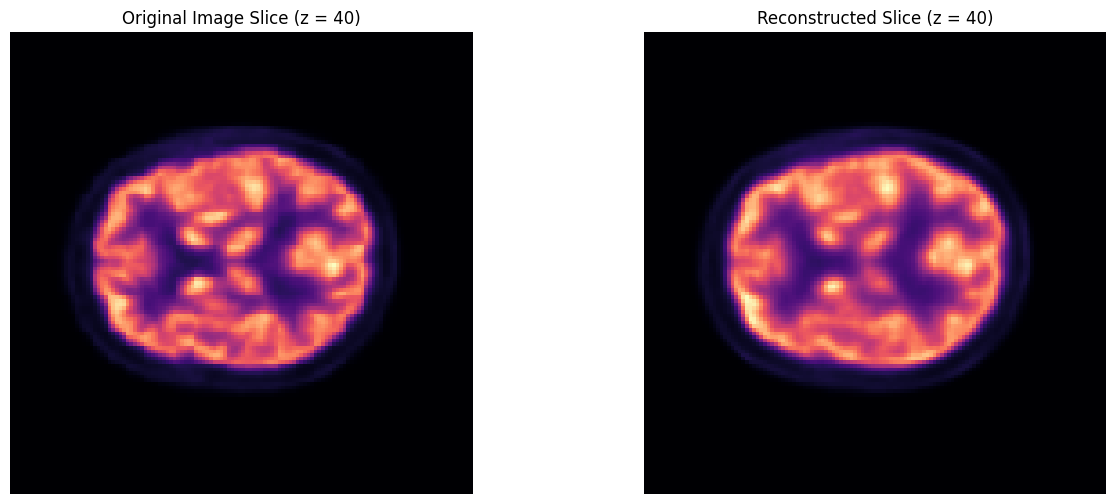

In [23]:
# -----------------------------------------------------------------------------
# 8. Display a reconstructed slice.
# -----------------------------------------------------------------------------
# We display the middle slice along the z-axis.
recon_image_align = recon_image.permute(2, 1, 0)
recon_image_align_flatten = recon_image_align.flatten()
orig_image = np.load(r"D:\Datasets\dataset\train_npy_crop\3d_image_9.npy")

slice_index = recon_image.shape[2] // 2 

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 6))

# Display the original image slice
plt.subplot(1, 2, 1)
plt.imshow(orig_image[slice_index, :, :], cmap='magma', interpolation='nearest')
plt.title(f'Original Image Slice (z = {slice_index})')
plt.axis('off')

# Display the reconstructed image slice
plt.subplot(1, 2, 2)
plt.imshow(recon_image_align[slice_index, :, :].cpu(), cmap='magma', interpolation='nearest')
plt.title(f'Reconstructed Slice (z = {slice_index})')
plt.axis('off')
# plt.savefig('images/reconstructed_image.png', dpi=600)
plt.show()

In [24]:
# -----------------------------------------------------------------------------
# 9. Optionally, save the reconstructed volume as a .npy file.
# -----------------------------------------------------------------------------
# np.save('reconstructed_128x128x128.npy', recon_image.cpu().numpy())

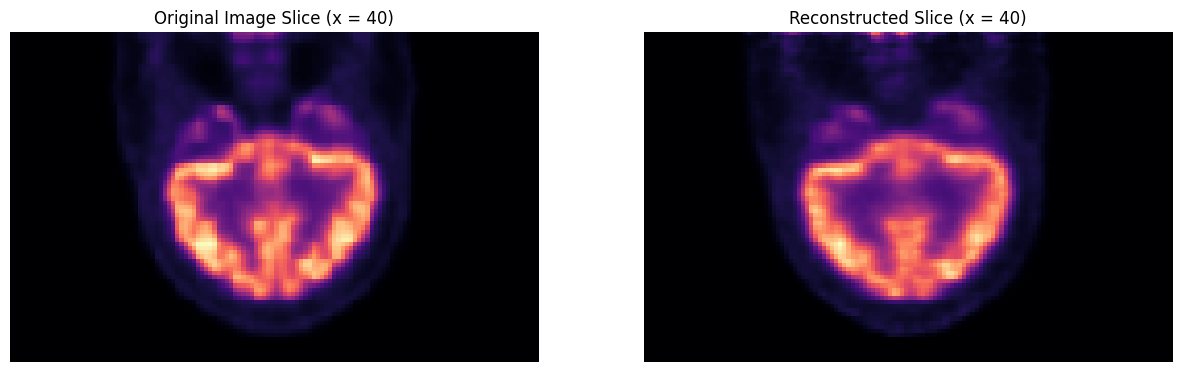

In [25]:
# -----------------------------------------------------------------------------
# 8. Display a reconstructed slice.
# -----------------------------------------------------------------------------
# We display the middle slice along the z-axis.

slice_index = recon_image.shape[2] // 2 

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 6))

# Display the original image slice
plt.subplot(1, 2, 1)
plt.imshow(orig_image[:, :, slice_index], cmap='magma', interpolation='nearest')
plt.title(f'Original Image Slice (x = {slice_index})')
plt.axis('off')

# Display the reconstructed image slice
plt.subplot(1, 2, 2)
plt.imshow(recon_image_align[:, :, slice_index].cpu(), cmap='magma', interpolation='nearest')
plt.title(f'Reconstructed Slice (x = {slice_index})')
plt.axis('off')
plt.show()

In [26]:
# recon_image_deleted = recon_image_align[10:, :, :]
# orig_image_deleted = orig_image[10:, :, :]

min_val = recon_image_align.min()
max_val = recon_image_align.max()
if max_val - min_val != 0:
    recon_image_scaled = (recon_image_align - min_val) / (max_val - min_val)
else:
    recon_image_scaled = recon_image_align.copy()

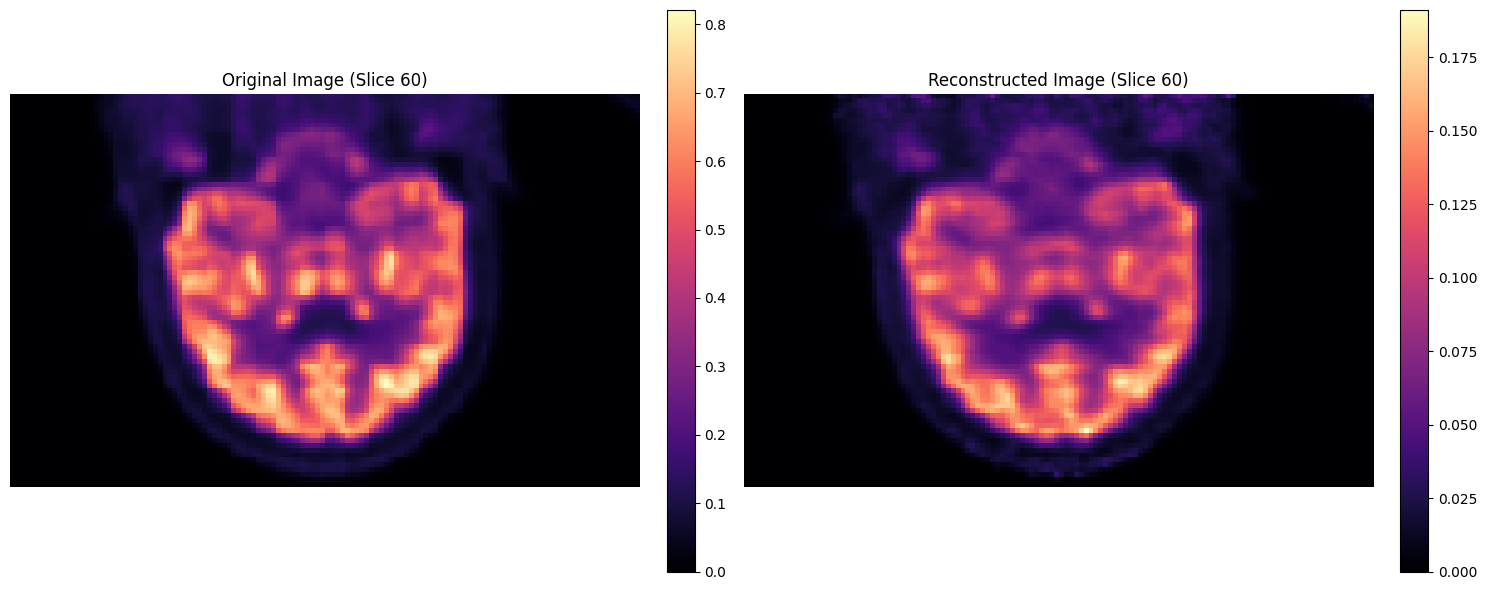

In [27]:

slice_index = recon_image.shape[2] // 2 + 20

# Create a figure with two subplots for side-by-side comparison.
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Display the original image slice with colorbar.
im0 = axs[0].imshow(orig_image[:, :, slice_index], cmap='magma', interpolation='nearest')
axs[0].set_title(f"Original Image (Slice {slice_index})")
axs[0].axis('off')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# Display the reconstructed image slice with colorbar.
im1 = axs[1].imshow(recon_image_scaled[:, :, slice_index].cpu(), cmap='magma', interpolation='nearest')
axs[1].set_title(f"Reconstructed Image (Slice {slice_index})")
axs[1].axis('off')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [28]:

# Example usage:
# Suppose recon_image_scaled is a torch tensor -> convert to numpy
recon_np = recon_image_scaled.cpu().numpy()
recon_np_normalized = (recon_np - recon_np.min()) / (recon_np.max() - recon_np.min())
# global_mask = global_outlier_detection(recon_np, factor=1.8, percentile=99.0)
# local_mask = local_outlier_detection(recon_np, window_size=3, sigma_factor=3)
# edge_mask = edge_outlier_detection(recon_np)
# # combined_mask = combined_outlier_detection(recon_np, 2.0, 99.0, 5, 3.0)
# combined_mask = analyze_outlier_masks(recon_np, global_mask, local_mask, edge_mask)
cleaned_image = remove_outliers_iteratively(recon_np_normalized, max_iters=10,
                                            global_factor=1.8, global_percentile=99.0,
                                            local_window=3, local_sigma=3.0)
# cleaned_image = recon_np_normalized

Iteration 1: found 76 outliers.
0.021508366
Iteration 2: found 205 outliers.
0.09748317
Iteration 3: found 24 outliers.
0.09748317
Iteration 4: found 11 outliers.
0.09748317
Iteration 5: found 2 outliers.
0.09748317
Iteration 6: found 2 outliers.
0.09748317
Iteration 7: found 0 outliers.
0.09748317
No more outliers. Stopping early.


In [29]:
# patched_image = inpaint_outliers_iterative(recon_np, combined_mask, max_radius=4)
patched_image = (cleaned_image - cleaned_image.min()) / (cleaned_image.max() - cleaned_image.min())

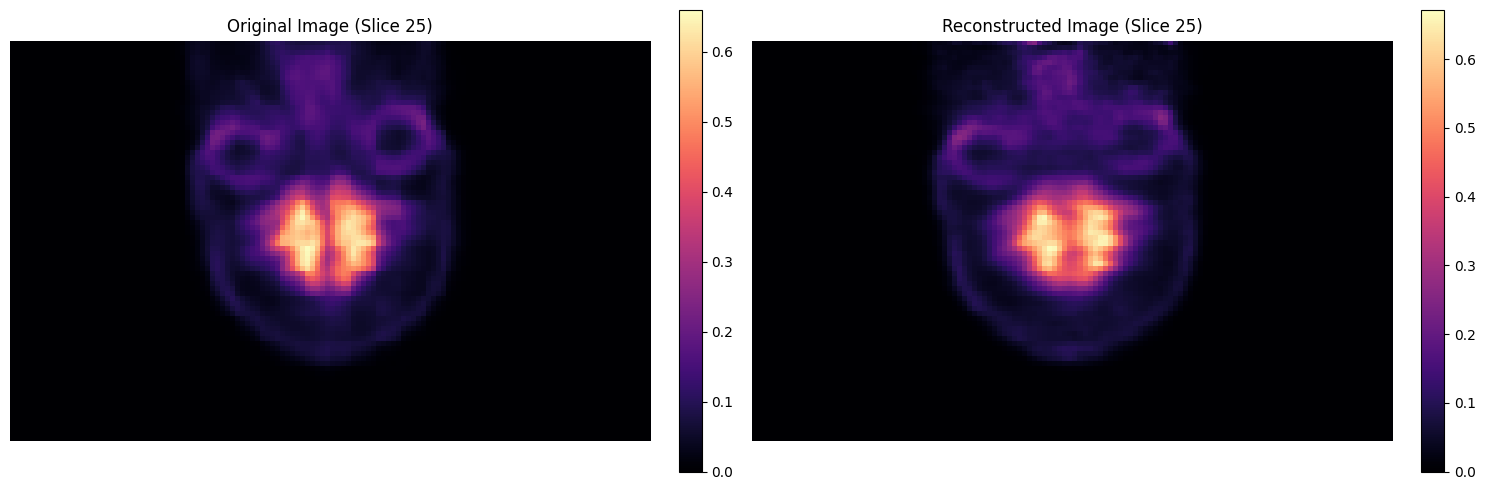

In [34]:
slice_index = recon_image.shape[2] // 2 - 15

# Create a figure with two subplots for side-by-side comparison.
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Display the original image slice with colorbar.
im0 = axs[0].imshow(orig_image[:, :, slice_index], cmap='magma', interpolation='nearest')
axs[0].set_title(f"Original Image (Slice {slice_index})")
axs[0].axis('off')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# Display the reconstructed image slice with colorbar.
im1 = axs[1].imshow(patched_image[:, :, slice_index], cmap='magma', interpolation='nearest')
axs[1].set_title(f"Reconstructed Image (Slice {slice_index})")
axs[1].axis('off')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



In [31]:
d = patched_image[:, :, slice_index]

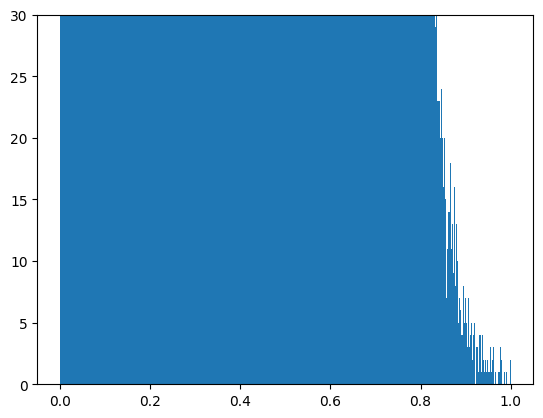

In [32]:
plt.hist(patched_image.flatten(), bins=500)
plt.ylim(0, 30)
plt.show()

In [33]:
np.percentile(recon_np, 99)

np.float32(0.15087923)